In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import pandas as pd
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
import torch.mps 
import itertools
import csv
from torchmetrics import Accuracy
import torchvision.models as models


In [2]:
# %%time
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("MPS found")
    device = torch.device("mps")
    

MPS found


In [3]:
train_folder_path = './data/FER2013Train'
test_folder_path = './data/FER2013Test'
valid_folder_path = './data/FER2013Valid'

In [4]:
class FERPlusDataset(Dataset):
    """FERPlus dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Get the unique classes from the emotions column
        self.classes = np.unique(self.img_frame.iloc[:, 2:]).tolist()
        
    def __len__(self):
        return len(self.img_frame)

#     to access elements using the []
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

#   to create the image name
        img_name = os.path.join(self.root_dir, self.img_frame.iloc[idx, 0])

        image = io.imread(img_name)
        emotions = self.img_frame.iloc[idx, 2:]
        emotions = np.asarray(emotions)
        emotions = emotions.astype('float32')

        sample = {'image': image, 'emotions': emotions} # a dictionary of an image with its label
        if self.transform:
            sample = self.transform(sample)

        return sample #return a transformed image with label
    
    
        

In [5]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, emotions = sample['image'], sample['emotions']

        # Convert grayscale image to RGB
        image_rgb = np.repeat(image[..., np.newaxis], 3, axis=-1)

        transform = transforms.ToTensor()

        return {'image': transform(image_rgb),
                'emotions': emotions}



train_dataset = FERPlusDataset(os.path.join(train_folder_path,"label.csv"), train_folder_path, transform=ToTensor())
valid_dataset = FERPlusDataset(os.path.join(valid_folder_path, "label.csv"), valid_folder_path, transform=ToTensor())
test_dataset = FERPlusDataset(os.path.join(test_folder_path, "label.csv"), test_folder_path, transform=ToTensor())


## Just for Debugging

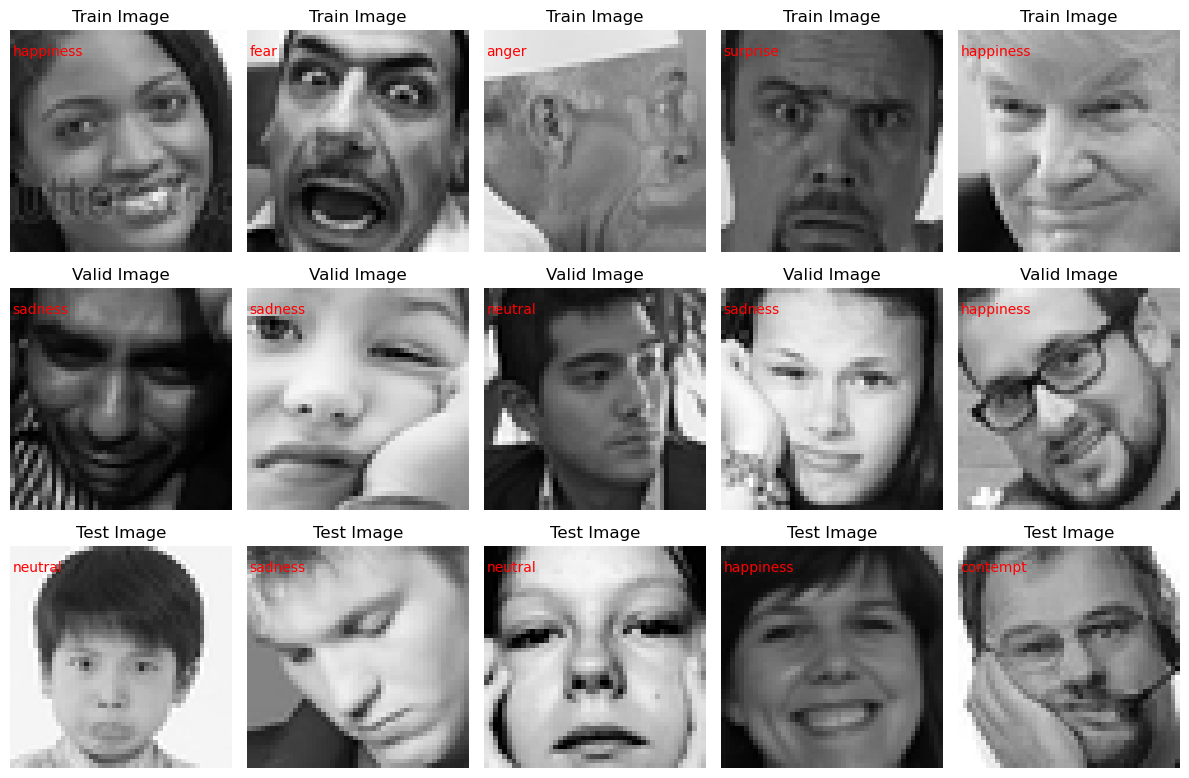

In [6]:
# Define the emotion labels
emotion_labels = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']

# Randomly select and display images from the train set
train_indices = np.random.choice(len(train_dataset), size=5, replace=False)
train_images = [train_dataset[i]['image'] for i in train_indices]
train_labels = [train_dataset[i]['emotions'] for i in train_indices]

# Randomly select and display images from the validation set
valid_indices = np.random.choice(len(valid_dataset), size=5, replace=False)
valid_images = [valid_dataset[i]['image'] for i in valid_indices]
valid_labels = [valid_dataset[i]['emotions'] for i in valid_indices]

# Randomly select and display images from the test set
test_indices = np.random.choice(len(test_dataset), size=5, replace=False)
test_images = [test_dataset[i]['image'] for i in test_indices]
test_labels = [test_dataset[i]['emotions'] for i in test_indices]

# Display the images and labels
fig, axes = plt.subplots(3, 5, figsize=(12, 8))

for i, (image, label) in enumerate(zip(train_images, train_labels)):
    axes[0, i].imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Train Image')
    axes[0, i].text(0, 5, emotion_labels[np.argmax(label)], color='red')

for i, (image, label) in enumerate(zip(valid_images, valid_labels)):
    axes[1, i].imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Valid Image')
    axes[1, i].text(0, 5, emotion_labels[np.argmax(label)], color='red')

for i, (image, label) in enumerate(zip(test_images, test_labels)):
    axes[2, i].imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')
    axes[2, i].axis('off')
    axes[2, i].set_title('Test Image')
    axes[2, i].text(0, 5, emotion_labels[np.argmax(label)], color='red')

plt.tight_layout()
plt.show()


In [7]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## Step 3: Load a pre-trained model and modify the classifier

In [8]:
model = models.resnet18(pretrained=True, progress=True)

num_classes = len(train_dataset.classes)
in_features = model.fc.in_features

# Modify the classifier
model.fc = nn.Linear(in_features, num_classes)


/Users/asserelfeki/dev/ml/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/asserelfeki/dev/ml/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 4: Define the loss function, optimizer, and training settings

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10

model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Step 5: Train the model

In [11]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        labels = data['emotions'].argmax(dim=1).to(device)  # Modify this line
        images = data['image'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'pretrained_resnet18.pt')


Epoch 1/10 - Loss: 1.1396
Epoch 2/10 - Loss: 0.7759
Epoch 3/10 - Loss: 0.6131
Epoch 4/10 - Loss: 0.4867
Epoch 5/10 - Loss: 0.3782
Epoch 6/10 - Loss: 0.3001
Epoch 7/10 - Loss: 0.2438
Epoch 8/10 - Loss: 0.1949
Epoch 9/10 - Loss: 0.1719
Epoch 10/10 - Loss: 0.1388


In [15]:
model.eval()  # Set the model to evaluation mode
val_loss = 0.0
val_correct = 0
total_samples = 0

with torch.no_grad():
    for data in valid_loader:
        labels = data['emotions'].to(device)
        images = data['image'].to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        
        val_loss += criterion(outputs, labels).item() 
        val_correct += torch.eq(predicted, labels).sum().item()
        total_samples += labels.size(0)
    
val_loss /= total_samples
val_accuracy = val_correct / total_samples

print(f'Validation Loss: {val_loss:.4f} | Accuracy: {val_accuracy * 100:.2f}%')


Validation Loss: 0.0366 | Accuracy: 75.24%


In [16]:
# dictionary for classess names in FERplus dataset
classes = {
    0: 'Neutral',
    1: 'Happinnes',
    2: 'Surprise',
    3: 'Sadness',
    4: 'Anger',
    5: 'Disgust',
    6: 'Fear',
    7: 'Contempt',
    8: 'Unknown',
    9: 'NF'
}

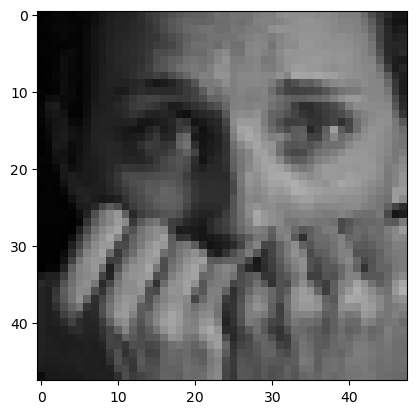

the original label was Fear



In [17]:
idx = 388

np_img = test_dataset[idx]['image']
plt.imshow(np.transpose(np_img, (1, 2, 0)))
plt.show()
plt.close()
print (f"the original label was {classes[test_dataset[idx]['emotions'].argmax(0).item()]}\n")


In [20]:
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=10).to(device)


In [22]:
# test model on the test data set
import torch.nn.functional as F
import torch
def test_model(model, test_loader, dataset):
    model.to('cpu')
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_accuracy = []
    wrong = 0
    with torch.inference_mode():
        for i, data in enumerate(test_loader):
            labels = data['emotions']
            inputs = data['image']
            output = model(inputs)
            # print("out: ", output.shape)
            # print("labels: ", labels.shape)
            # print(labels.shape)
            # print(f"test loader length:  {len(test_loader)}")
            # show the first 10 images and their truth labels and their predictions
            if i < len(test_loader):
                for j in range(len(inputs)):
                    # if classes[labels[j].argmax(0).item()] != classes[output[j].argmax(0).item()] :
                    #     wrong +=1
                    
                    
                    file_name = "mymodel.txt"
                    output_file = open(file_name, "a")
                    prediction = classes[labels[j].argmax(0).item()] == classes[output[j].argmax(0).item()]
                    
                    output_file.write(f"image: {i * batch_size + j} was {prediction}\n")
                    output_file.write(f"predicted label was: {classes[output[j].argmax(0).item()]} and the original label was {classes[labels[j].argmax(0).item()]}\n")
                    output_file.write("="*50)
                    output_file.write("\n")
                    # if j == 10:
                    #     print("one example:")
                    #     np_img = test_dataset[i * batch_size + j]['image']
                    #     plt.imshow(np.transpose(np_img, (1, 2, 0)))
                    #     plt.show()
                    #     plt.close()
                    #     print('-'*50)
                        
                    # print(labels[i].argmax().item())
                    # if classes[labels[j].argmax(0).item()] == classes[output[j].argmax(0).item()]:
                    #     print("hoppppaaaaaaaaaa")
                    #     print('image:', i * batch_size + j)
                        
                    #     print('truth:', classes[labels[j].argmax(0).item()])
                    #     print('prediction:', classes[output[j].argmax(0).item()])
                    #     print('='*50)
                    # plt.close('all')    
            output_file.close()
            # measure accuracy
            _, predicted = torch.max(output, 1)
            _, labels = torch.max(labels, 1)
            # torchmetrics_accuracy(predicted, labels)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_accuracy.append(torchmetrics_accuracy(predicted, labels))
        # print total accuracy
        print('Accuracy of the network on the test images: %d %%' % (
            100 * correct / total))
        print(f"correct: {correct}, total: {total}")
        print(test_accuracy)
test_model(model, test_loader, test_dataset)

Accuracy of the network on the test images: 74 %
correct: 2663, total: 3572
[tensor(0.8125, device='mps:0'), tensor(0.6562, device='mps:0'), tensor(0.8125, device='mps:0'), tensor(0.8125, device='mps:0'), tensor(0.7500, device='mps:0'), tensor(0.7188, device='mps:0'), tensor(0.7188, device='mps:0'), tensor(0.6562, device='mps:0'), tensor(0.6562, device='mps:0'), tensor(0.6562, device='mps:0'), tensor(0.7812, device='mps:0'), tensor(0.7188, device='mps:0'), tensor(0.7500, device='mps:0'), tensor(0.7500, device='mps:0'), tensor(0.7500, device='mps:0'), tensor(0.7500, device='mps:0'), tensor(0.7500, device='mps:0'), tensor(0.6875, device='mps:0'), tensor(0.7188, device='mps:0'), tensor(0.7812, device='mps:0'), tensor(0.5938, device='mps:0'), tensor(0.7812, device='mps:0'), tensor(0.6562, device='mps:0'), tensor(0.7188, device='mps:0'), tensor(0.6562, device='mps:0'), tensor(0.6875, device='mps:0'), tensor(0.7500, device='mps:0'), tensor(0.6562, device='mps:0'), tensor(0.8750, device='mps:

In [25]:
model.to(device)
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
total_samples = 0

with torch.no_grad():
    for data in test_loader:
        labels = data['emotions'].to(device)
        images = data['image'].to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels, 1)
        
        test_loss += criterion(outputs, labels).item() 
        test_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
test_loss /= total_samples
test_accuracy = test_correct / total_samples

print(f'Test Loss: {test_loss:.4f} | Accuracy: {test_accuracy * 100:.2f}%')


Test Loss: 0.0391 | Accuracy: 74.55%
